In [3]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma, _ewma_mean, _ewma_cov
from cvx.covariance.combination import from_sigmas, from_ewmas
from cvx.covariance.regularization import regularize_covariance, em_regularize_covariance
from experiments.utils.experiment_utils import *
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:


# import test data
returns = (
    pd.read_csv(
        "../../tests/resources/stock_prices.csv", index_col=0, header=0, parse_dates=True
    )
    .ffill()
    .pct_change()
    .iloc[1:]
)

# np.random.seed(0)
# mask = np.random.choice([False, True], size=returns.shape, p=[0.9, 0.1])
# returns[mask] = np.nan



In [78]:
half_life_pairs = [(10,21), (21, 63)]

iterator = from_ewmas(returns, half_life_pairs).solve(window=5, smoother="l1", gamma=1, solver="ECOS")

covariances = {}
weights = {}
for iterate in iterator:
    covariances[iterate.time] = iterate.covariance
    weights[iterate.time] = iterate.weights

weights = pd.DataFrame(weights).T
cov = covariances[time_stamp]

In [84]:
half_life_pairs = [(10,21), (21, 63)]

iterator = from_ewmas(returns, half_life_pairs).solve(window=5, smoother="l1", gamma=1, solver="CLARABEL")

covariances2 = {}
weights2 = {}
for iterate in iterator:
    covariances2[iterate.time] = iterate.covariance
    weights2[iterate.time] = iterate.weights

weights2 = pd.DataFrame(weights2).T
cov2 = covariances2[time_stamp]

In [88]:
pd.testing.assert_frame_equal(weights, weights2, atol=1e-4)

In [80]:
weights2

,10-21,21-63
2017-03-08,5.008324e-11,1.000000
2017-03-09,1.088468e-09,1.000000
2017-03-10,1.784249e-09,1.000000
2017-03-13,1.954649e-09,1.000000
2017-03-14,2.805541e-09,1.000000
...,...,...
2018-04-05,1.023512e-01,0.897649
2018-04-06,1.023513e-01,0.897649
2018-04-09,1.603874e-01,0.839613
2018-04-10,1.603874e-01,0.839613


<Axes: >

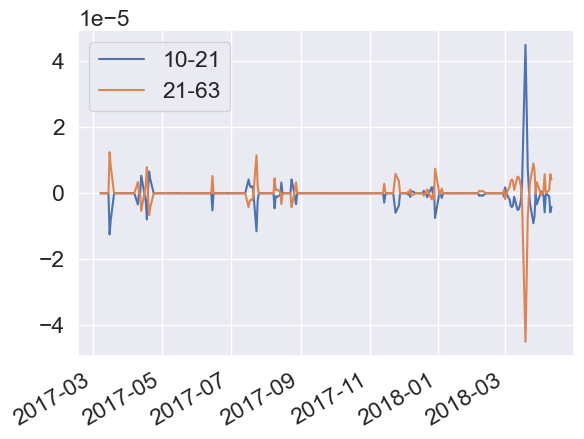

In [65]:
(weights-weights2).plot()


<Axes: >

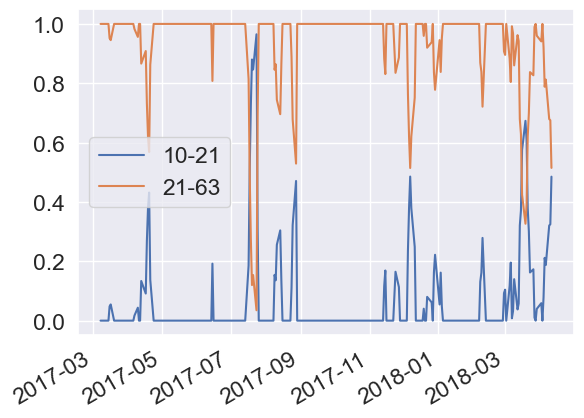

In [55]:
covariances[time_stamp].index

Index(['GOOG', 'AAPL', 'FB', 'BABA', 'AMZN', 'GE', 'AMD', 'WMT', 'BAC', 'GM',
       'T', 'UAA', 'SHLD', 'XOM', 'RRC', 'BBY', 'MA', 'PFE', 'JPM', 'SBUX'],
      dtype='object')

In [57]:
weights.index

DatetimeIndex(['2017-03-08', '2017-03-09', '2017-03-10', '2017-03-13',
               '2017-03-14', '2017-03-15', '2017-03-16', '2017-03-17',
               '2017-03-20', '2017-03-21',
               ...
               '2018-03-28', '2018-03-29', '2018-04-02', '2018-04-03',
               '2018-04-04', '2018-04-05', '2018-04-06', '2018-04-09',
               '2018-04-10', '2018-04-11'],
              dtype='datetime64[ns]', length=276, freq=None)

In [44]:
returns = pd.read_csv(
    "../data/49_industries.csv", index_col=0, header=0, parse_dates=True
)

In [40]:
iewma_pair = (63, 125)
iewma = list(
    iterated_ewma(
        returns,
        vola_halflife=iewma_pair[0],
        cov_halflife=iewma_pair[1],
        min_periods_vola=0,
        min_periods_cov=0,
        nan_to_num=True,
    )
)
iewma = {iterate.time: iterate.covariance for iterate in iewma}

covariance = iewma[returns.index[-1]]

In [52]:
iewma_pair = (63, 125)


In [184]:
# 10 percent random nans

np.random.seed(0)
mask = np.random.choice([True, False], size=returns.iloc[:5000].shape, p=[0.1, 0.9])

returns_nans = returns.copy()
# returns_nans.iloc[:5000][mask] = np.nan
returns_nans.iloc[:5000, 0] = np.nan


In [53]:
times = returns_nans.index

In [194]:
iewma = list(
    iterated_ewma(
        returns,
        vola_halflife=iewma_pair[0],
        cov_halflife=iewma_pair[1],
        min_periods_vola=0,
        min_periods_cov=0,
        nan_to_num=True,
    )
)
iewma = {iterate.time: iterate.covariance for iterate in iewma}


In [196]:
iewma_nans = list(
    iterated_ewma(
        returns_nans,
        vola_halflife=iewma_pair[0],
        cov_halflife=iewma_pair[1],
        min_periods_vola=0,
        min_periods_cov=0,
        nan_to_num=True,
        mean=False,
    )
)
iewma_nans = {iterate.time: iterate.covariance for iterate in iewma_nans}


In [187]:
deviation = []
deviation2 = []

for time_prev, time in zip(times[:-1], times[1:]):
    deviation.append(np.linalg.norm(iewma[time] - iewma_nans[time]))
    deviation2.append(np.linalg.norm(iewma[time] - iewma[time_prev]))

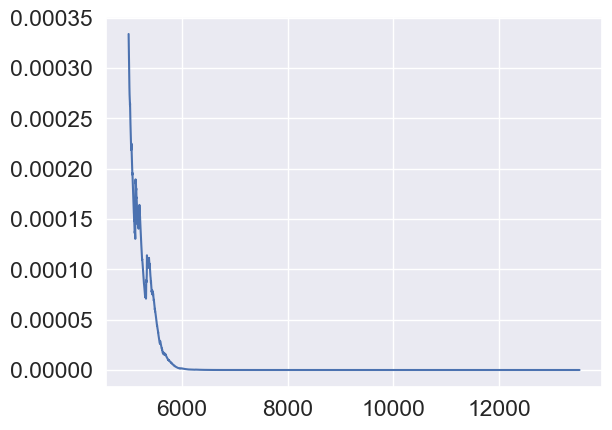

In [190]:
plt.plot(deviation)
# plt.plot(deviation2)